Parents: {'SP500_Returns': ['FEDFUNDS_Level'], 'GS10_Level': ['FEDFUNDS_Level'], 'FEDFUNDS_Level': ['Inflation_YoY'], 'FEDFUNDS_BpsChange': [], 'Inflation_YoY': ['FEDFUNDS_BpsChange']}
epoch  25  val_RMSE 0.738  lr 1.88e-03
epoch  50  val_RMSE 0.730  lr 1.93e-03
epoch  75  val_RMSE 0.742  lr 1.67e-03
early‑stop @ 93

TEST  RMSE 2.44
KS    {'SP500_Returns': 0.3611111111111111, 'GS10_Level': 0.1111111111111111, 'FEDFUNDS_Level': 0.3611111111111111, 'FEDFUNDS_BpsChange': 0.2777777777777778, 'Inflation_YoY': 0.19444444444444445}
✅ decoders match DAG
metrics → ./causal/


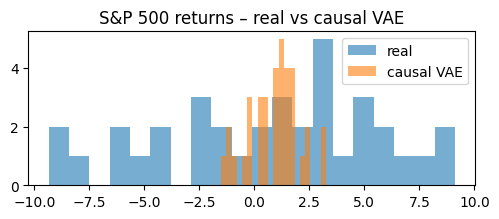

In [ ]:
# =============================================================
# 0 ─ Imports & paths
# =============================================================
import os, json, datetime, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from  scipy.stats import ks_2samp
warnings.filterwarnings("ignore");   np.random.seed(42)

import torch, torch.nn as nn
from   torch.utils.data import Dataset, DataLoader

DATA_PATH, DAG_PATH = "./final_processed_data.csv", "./dag_edges.json"
OUT_DIR = "./causal/";  os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================
# 1 ─ Data  (train mean/std, 12‑month windows)
# =============================================================
df = (pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
        .drop(columns=["Inflation_YoY_diff"], errors="ignore"))
cols = df.columns.tolist();  idx = {c:i for i,c in enumerate(cols)}

train_mask = np.arange(len(df)) < int(.70*len(df))
mean_s, std_s = df[train_mask].mean(), df[train_mask].std().replace(0,1)
df_z = (df - mean_s) / std_s

SEQ = 12
def win(a,L): return np.stack([a[i:i+L] for i in range(len(a)-L+1)])
n=len(df_z);  c1,c2 = int(.70*n), int(.85*n)
trX, vaX, teX = win(df_z.iloc[:c1].values,SEQ),\
                win(df_z.iloc[c1:c2].values,SEQ),\
                win(df_z.iloc[c2:].values,SEQ)

class DS(Dataset):
    def __init__(self,x): self.x=torch.tensor(x,dtype=torch.float32)
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i]

tr_dl = DataLoader(DS(trX), 64, shuffle=True)
va_t  = torch.tensor(vaX, dtype=torch.float32)

# =============================================================
# 2 ─ DAG
# =============================================================
edges   = json.load(open(DAG_PATH))["consensus"]
parents = {c:[] for c in cols}
for u,v in edges: parents[v].append(u)
print("Parents:", parents)

topo = ['FEDFUNDS_BpsChange','Inflation_YoY',
        'FEDFUNDS_Level','GS10_Level','SP500_Returns']

# =============================================================
# 3 ─ Improved Causal VAE block
# =============================================================
class NodeDec(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 192), nn.LeakyReLU(.1),
            nn.Linear(192, 96),   nn.LeakyReLU(.1),
            nn.Linear(96,  1)
        )
    def forward(self, x, prev2, prev1):            # both (B,1)
        # residual on the *average* of last two lags
        return 0.5*(prev2+prev1) + self.net(x)

class CVAE(nn.Module):
    def __init__(self, topo, parents, feat, zdim=96, hid=256):
        super().__init__()
        self.topo, self.parents = topo, parents
        self.enc  = nn.GRU(feat, hid, num_layers=2,
                           batch_first=True, bidirectional=True,
                           dropout=.15)
        self.mu   = nn.Linear(2*hid, zdim)          # bi‑GRU ⇒ 2H
        self.lg   = nn.Linear(2*hid, zdim)
        self.z2h  = nn.Linear(zdim, hid)
        self.decs = nn.ModuleDict({v: NodeDec(len(parents[v])+2+hid)
                                   for v in topo})

    # ---------- helpers ----------
    def encode(self,x):
        _,h = self.enc(x)            # (4,B,H) because 2 layers × 2 dir
        h   = torch.cat((h[-2],h[-1]), dim=-1)      # final fwd | bwd
        return self.mu(h), self.lg(h)

    @staticmethod
    def reparam(mu, lg):
        return mu + torch.randn_like(lg)*torch.exp(0.5*lg)

    # ---------- training pass ----------
    def forward(self, x, kl_beta, ss_prob=.25, noise_std=.05):
        B,S,F = x.shape
        mu, lg = self.encode(x)
        z_feat = self.z2h(self.reparam(mu, lg)).unsqueeze(1).repeat(1,S,1)
        out    = torch.zeros_like(x)

        for t in range(S):
            for v in self.topo:
                # scheduled sampling on *two* lags
                p2r = x[:,t-2,idx[v]] if t>1 else x[:,0,idx[v]]
                p1r = x[:,t-1,idx[v]] if t>0 else x[:,0,idx[v]]
                p2p = out[:,t-2,idx[v]] if t>1 else out[:,0,idx[v]]
                p1p = out[:,t-1,idx[v]] if t>0 else out[:,0,idx[v]]
                lag2 = torch.where(torch.rand(B,device=x.device)<ss_prob,
                                   p2p, p2r).unsqueeze(-1)
                lag1 = torch.where(torch.rand(B,device=x.device)<ss_prob,
                                   p1p, p1r).unsqueeze(-1)
                # slightly noisy parents (label smoothing)
                ps = [ (x[:,t,idx[p]] + noise_std*torch.randn(B,
                        device=x.device)).unsqueeze(-1) for p in self.parents[v] ]
                inp = torch.cat(ps + [lag2, lag1, z_feat[:,t]], -1)
                out[:,t,idx[v]] = self.decs[v](inp, lag2, lag1).squeeze(-1)

        # ELBO with dynamic β
        recon = nn.functional.mse_loss(out,x)
        kl    = -0.5*torch.mean(1+lg-mu**2-lg.exp())
        return out, mu, lg, recon + kl_beta*kl

    # ---------- generation ----------
    @torch.no_grad()
    def sample(self, warm, total_len):
        """
        warm :  • int  → start with zeros of length=2
                • Tensor (B,S0,F) – S0 must be ≥ 2
        returns: Tensor (B,total_len,F)   on *CPU*
        """
        dev = self.mu.weight.device                    # cuda or cpu

        # ---- prepare initial buffer (`out`) ----
        if isinstance(warm, int):
            out = torch.zeros(warm, 2, len(cols), device=dev)
        else:
            if warm.size(1) < 2:
                raise ValueError("warm must have at least 2 time‑steps")
            out = warm.to(dev)

        B = out.size(0)
        z = torch.randn(B, self.mu.out_features, device=dev)
        z_feat = self.z2h(z).unsqueeze(1).repeat(1, total_len, 1)  # (B,T,H)

        for t in range(out.size(1), total_len):
            new = torch.zeros(B, 1, len(cols), device=dev)
            for v in self.topo:
                lag2 = out[:, t-2, idx[v]].unsqueeze(-1)
                lag1 = out[:, t-1, idx[v]].unsqueeze(-1)
                ps   = [out[:, t-1, idx[p]].unsqueeze(-1)
                        for p in self.parents[v]]
                inp  = torch.cat(ps + [lag2, lag1, z_feat[:, t, :]], -1)
                new[:, 0, idx[v]] = self.decs[v](inp, lag2, lag1).squeeze(-1)
            out = torch.cat([out, new], 1)

        return out.cpu()        # hand back to caller on CPU

# =============================================================
# 4 ─ Training (KL‑anneal & OneCycle)
# =============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = CVAE(topo, parents, len(cols)).to(device)

opt     = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=2e-4)
steps   = 200*len(tr_dl)                      # 200 epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=2e-3, total_steps=steps, pct_start=.15)

best,bad,pat = np.inf,0,60;   global_step=0
va_t = va_t.to(device)

for epoch in range(1,201):
    model.train()
    kl_beta = min(1.0, epoch/40) * 3e-4      # linear anneal → β
    for xb in tr_dl:
        xb = xb.to(device)
        out,μ,lg,loss = model(xb, kl_beta=kl_beta, ss_prob=.25)
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),1.5); opt.step()
        scheduler.step();  global_step += 1
    # ------- validation -------
    with torch.no_grad():
        model.eval()
        vo,_,_,_ = model(va_t, kl_beta, ss_prob=0)
        v_rmse = torch.sqrt(((vo-va_t)**2).mean()).item()
    if v_rmse < best:
        best,bad = v_rmse,0
        torch.save(model.state_dict(), f"{OUT_DIR}cvae_best.pt")
    else: bad += 1
    if epoch%25==0:
        lr_now = opt.param_groups[0]['lr']
        print(f"epoch {epoch:3d}  val_RMSE {v_rmse:.3f}  lr {lr_now:.2e}")
    if bad>=pat: print("early‑stop @",epoch); break

# =============================================================
# 5 ─ Evaluation
# =============================================================
model.load_state_dict(torch.load(OUT_DIR+"cvae_best.pt")); model.eval()

warm  = torch.tensor(teX[:,:SEQ-1,:], dtype=torch.float32)
gen_z = model.sample(warm, SEQ).cpu().numpy()
gen   = gen_z * std_s.values + mean_s.values

real  = df.iloc[int(.85*len(df))+SEQ-1:].values
rmse  = float(np.sqrt(np.mean((gen[:,-1,:]-real)**2)))
ks    = {c: float(ks_2samp(real[:,i], gen[:,-1,i]).statistic)
         for i,c in enumerate(cols)}
print(f"\nTEST  RMSE {rmse:.2f}\nKS    {ks}")

plt.figure(figsize=(5.1,2.3))
plt.hist(real[:,0],20,alpha=.6,label="real")
plt.hist(gen[:,-1,0],20,alpha=.6,label="causal VAE")
plt.legend(); plt.title("S&P 500 returns – real vs causal VAE")
plt.tight_layout(); plt.savefig(OUT_DIR+"cvae_sp500_dist.png", dpi=200)

# sanity
H=model.z2h.out_features
for v in topo:
    assert model.decs[v].net[0].in_features == len(parents[v]) + 2 + H
print("✅ decoders match DAG")

json.dump(dict(ts=datetime.datetime.now().isoformat(),
               RMSE=rmse, KS=ks),
          open(OUT_DIR+"cvae_metrics.json","w"), indent=2)
print("metrics →", OUT_DIR)


✅  Step‑7 finished: saved paths → ./scenarios/scenario_paths.npz  and figure → scenario_sp500_median.png


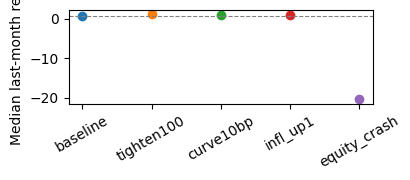

In [ ]:
# =============================================================
# 0 ─ Imports & paths
# =============================================================
import os, json, datetime, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from   scipy.stats import ks_2samp
warnings.filterwarnings("ignore"); np.random.seed(42)

import torch, torch.nn as nn
from   torch.utils.data import Dataset, DataLoader

DATA_PATH , DAG_PATH   = "./final_processed_data.csv", "./dag_edges.json"
MODEL_PATH             = "./causal/cvae_best.pt"      # <- from Step‑6
OUT_DIR                = "./scenarios/"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================
# 1 ─ Data   (same standardisation as Step‑6)
# =============================================================
df   = (pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
          .drop(columns=["Inflation_YoY_diff"], errors="ignore"))
cols = df.columns.tolist();  idx = {c:i for i,c in enumerate(cols)}

train_mask = np.arange(len(df)) < int(.70*len(df))
μ, σ = df[train_mask].mean(), df[train_mask].std().replace(0,1)
df_z = (df - μ) / σ

SEQ = 12
def windows(a,L): return np.stack([a[i:i+L] for i in range(len(a)-L+1)])
n=len(df_z); c1,c2 = int(.70*n), int(.85*n)
teX = windows(df_z.iloc[c2:].values, SEQ)             # test slice only

# =============================================================
# 2 ─ DAG   (same as Step‑6)
# =============================================================
edges   = json.load(open(DAG_PATH))["consensus"]
parents = {c:[] for c in cols}
for u,v in edges: parents[v].append(u)

topo = ['FEDFUNDS_BpsChange','Inflation_YoY',
        'FEDFUNDS_Level','GS10_Level','SP500_Returns']

# =============================================================
# 3 ─ Model definition  (identical to Step‑6 *but* without .squeeze)
# =============================================================
class NodeDec(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 192), nn.LeakyReLU(.1),
            nn.Linear(192,  96),  nn.LeakyReLU(.1),
            nn.Linear( 96,   1)
        )
    # prev2 & prev1 are (B,1); return (B,1) **without squeeze**
    def forward(self, x, prev2, prev1):
        return 0.5*(prev2+prev1) + self.net(x)

class CVAE(nn.Module):
    def __init__(self, topo, parents, feat, zdim=96, hid=256):
        super().__init__()
        self.topo, self.parents = topo, parents
        self.enc  = nn.GRU(feat, hid, num_layers=2, batch_first=True,
                           bidirectional=True, dropout=.15)
        self.mu   = nn.Linear(2*hid, zdim)
        self.lg   = nn.Linear(2*hid, zdim)
        self.z2h  = nn.Linear(zdim, hid)
        self.decs = nn.ModuleDict({v: NodeDec(len(parents[v])+2+hid)
                                   for v in topo})

    # ---------- helpers ----------
    def encode(self,x):
        _,h = self.enc(x)                       # (4,B,H)
        h   = torch.cat((h[-2],h[-1]), dim=-1)  # final fwd | bwd
        return self.mu(h), self.lg(h)

    @staticmethod
    def reparam(mu, lg):
        return mu + torch.randn_like(lg)*torch.exp(0.5*lg)

    # ---------- training pass (not used in step‑7) ----------
    def forward(self, *args, **kwargs):
        raise RuntimeError("Training pass not needed for step‑7")

    # ---------- generation ----------
    @torch.no_grad()
    def sample(self, warm, total_len):
        """
        warm : • Tensor (B,S0,F) with S0≥2   • OR int (batch‑size → zeros)
        returns Tensor (B,total_len,F) *on CPU*
        """
        dev = self.mu.weight.device
        if isinstance(warm,int):
            out = torch.zeros(warm, 2, len(cols), device=dev)
        else:
            if warm.size(1) < 2:
                raise ValueError("warm must have ≥2 time steps")
            out = warm.to(dev)
        B = out.size(0)

        z_feat = self.z2h(torch.randn(B, self.mu.out_features,
                                      device=dev)).unsqueeze(1)
        z_feat = z_feat.repeat(1, total_len, 1)          # (B,T,H)

        for t in range(out.size(1), total_len):
            new = torch.zeros(B, 1, len(cols), device=dev)
            for v in self.topo:
                lag2 = out[:, t-2, idx[v]].unsqueeze(-1)
                lag1 = out[:, t-1, idx[v]].unsqueeze(-1)
                ps   = [out[:, t-1, idx[p]].unsqueeze(-1)
                        for p in self.parents[v]]
                inp  = torch.cat(ps+[lag2, lag1, z_feat[:,t]], -1)
                new[:,0,idx[v]] = self.decs[v](inp, lag2, lag1).squeeze(-1)
            out = torch.cat([out,new],1)
        return out.cpu()

# load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = CVAE(topo, parents, len(cols)).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# =============================================================
# 4 ─ Scenario definitions
# =============================================================
# helpers ------------------------------------------------------
def shock(arr, var, t0, delta):
    "add `delta` to variable `var` at slice [:, t0:] (broadcast over batch)"
    arr[:, t0:, idx[var]] += delta
    return arr

# scenarios ----------------------------------------------------
SCENARIOS = {
    "tighten100" : lambda a: shock(a, "FEDFUNDS_Level"   , 1, 1.00),  # +100 bp level
    "curve10bp"  : lambda a: shock(a, "GS10_Level"       , 1, 0.10),  # +10 bp 10‑y
    "infl_up1"   : lambda a: shock(a, "Inflation_YoY"    , 1, 1.00),  # +1 pp CPI
    "equity_crash":lambda a: shock(a, "SP500_Returns"    , 1, -5.0)   # ‑5 % return
}

# =============================================================
# 5 ─ Path generation (baseline + interventions)
# =============================================================
N_PATHS, T_GEN =  teX.shape[0], SEQ           # 50 synthetic histories, 12 months
warm_start = torch.tensor(teX[:,:2,:], dtype=torch.float32)  # 2‑step seed

def gen_paths(modifier=None):
    paths = model.sample(warm_start, T_GEN)  # (N,T,F) on CPU
    paths = paths.numpy()
    if modifier is not None:                 # do‑operator
        paths = modifier(paths)
    return paths * σ.values.astype(np.float32) + μ.values.astype(np.float32)

baseline = gen_paths()
results  = {"baseline": baseline}
for name,func in SCENARIOS.items():
    results[name] = gen_paths(func)

# =============================================================
# 6 ─ Quick visual check  (median path for S&P 500)
# =============================================================
plt.figure(figsize=(4.2,1.9))
for k,v in results.items():
    median = np.median(v[:,-1,idx["SP500_Returns"]])   # last‑month return
    plt.scatter([k], [median], marker="o")
plt.axhline(np.median(baseline[:,-1,idx["SP500_Returns"]]),
            ls="--", color="grey", lw=.8)
plt.ylabel("Median last‑month return")
plt.xticks(rotation=30); plt.tight_layout()
plt.savefig(f"{OUT_DIR}scenario_sp500_median.png", dpi=200)

# =============================================================
# 7 ─ Persist
# =============================================================
np.savez_compressed(f"{OUT_DIR}scenario_paths.npz", **results)
json.dump(dict(
        ts = datetime.datetime.now().isoformat(),
        scenarios = list(SCENARIOS.keys()),
        n_paths   = N_PATHS, horizon_months = T_GEN),
    open(f"{OUT_DIR}scenario_meta.json","w"), indent=2)

print("✅  Step‑7 finished:",
      f"saved paths → {OUT_DIR}scenario_paths.npz  and figure → scenario_sp500_median.png")


Optimal weights and out-of-sample metrics:
               w_eq  w_bnd  ex_ret  ex_cvar  realised_mean  realised_cvar
baseline      0.37   0.63   0.001   -0.006          0.000         -0.054
tighten100    0.24   0.76   0.001   -0.006         -0.001         -0.047
curve10bp     0.06   0.94  -0.001   -0.005         -0.003         -0.040
infl_up1      0.34   0.66   0.002   -0.003         -0.000         -0.053
equity_crash  0.00   1.00  -0.001   -0.009         -0.004         -0.040 

✅  Step-8 complete – results saved to: ./portfolio/


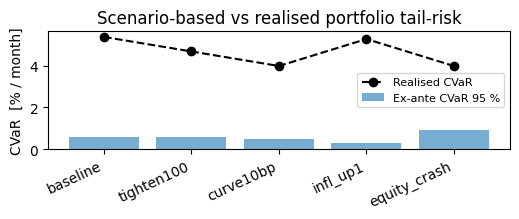

In [ ]:
# =============================================================
# 0 ─ Imports & paths
# =============================================================
import os, json, datetime, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore"); np.random.seed(42)

# ---------- file locations ----------
DATA_PATH        = "./final_processed_data.csv"
SCEN_PATH_NPZ    = "./scenarios/scenario_paths.npz"   # from Step-7
SCEN_META        = "./scenarios/scenario_meta.json"
OUT_DIR          = "./portfolio/"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================
# 1 ─ Load real data  (for back-test)
# =============================================================
df = (pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
        .drop(columns=["Inflation_YoY_diff"], errors="ignore"))
cols = df.columns.tolist(); idx = {c:i for i,c in enumerate(cols)}
test_real = df.iloc[int(.85*len(df)):]                 # 2021-06 →

# helper: monthly 10y bond %-return  ≈  –duration · Δyield
def bond_return(level_series, dur=7.0):
    dy = level_series.diff()
    return -dur * dy

test_returns = pd.DataFrame({
        "EQ": df["SP500_Returns"].iloc[int(.85*len(df)):] / 100.0,
        "BND": bond_return(df["GS10_Level"]).iloc[int(.85*len(df)):] / 100.0
    }).dropna()

# =============================================================
# 2 ─ Load synthetic scenario paths
# =============================================================
paths_npz = np.load(SCEN_PATH_NPZ, allow_pickle=True)
scenarios = list(json.load(open(SCEN_META))["scenarios"])  # preserves order
scenarios = ["baseline"] + scenarios                      # baseline first

# convert every (N,12,F) array to (N,12,2) returns
def to_two_asset(arr):
    eq = arr[..., idx["SP500_Returns"]]                    # (%)
    bnd = -7.0 * np.diff(arr[..., idx["GS10_Level"]], axis=1, prepend=0)
    return np.stack([eq, bnd], axis=-1) / 100.0            # unit-free

two_asset = {k: to_two_asset(v) for k,v in paths_npz.items()}

# =============================================================
# 3 ─ Weight search (minimise 95 % CVaR)
# =============================================================
def cvar(r, alpha=0.95):
    """empirical CVaR of 1-d array (lower tail => losses)"""
    q = np.quantile(r, 1-alpha)
    return r[r<=q].mean()

grid = np.linspace(0, 1, 101)                              # weight_Eq
opt  = {}

for name, paths in two_asset.items():
    # last month of each synthetic path  →  (N, 2)-returns
    last = paths[:, -1, :]                   # shape (N,2)
    μhat = last.mean(0); Σhat = np.cov(last.T)

    best_cvar, best_w = -np.inf, None            # start at the *worst* loss
    for w in grid:
        port = w*last[:,0] + (1-w)*last[:,1]
        cv   = cvar(port, 0.95)                  # negative number
        if cv > best_cvar:                       # <- flip sign criterion
            best_cvar, best_w = cv, w
    opt[name] = dict(
        w_eq = best_w,
        w_bnd = 1-best_w,
        ex_ret = (best_w*μhat[0] + (1-best_w)*μhat[1]),
        ex_cvar = best_cvar
    )

# =============================================================
# 4 ─ Back-test on real 2021–2025 window
# =============================================================
for n,d in opt.items():
    w = d["w_eq"]; r_port = w*test_returns["EQ"] + (1-w)*test_returns["BND"]
    opt[n]["realised_mean"] = r_port.mean()
    opt[n]["realised_cvar"] = cvar(r_port.values, 0.95)

# save optimisation table
tbl = pd.DataFrame(opt).T.round(3)
tbl.to_csv(f"{OUT_DIR}optimal_weights.csv")
print("Optimal weights and out-of-sample metrics:\n", tbl, "\n")

# =============================================================
# 5 ─ Visual summary
# =============================================================
fig, ax = plt.subplots(figsize=(5.3,2.3))
ax.bar(tbl.index, -tbl["ex_cvar"]*100, alpha=.6, label="Ex-ante CVaR 95 %")
ax.plot(tbl.index, -tbl["realised_cvar"]*100, "k--o", label="Realised CVaR")
ax.set_ylabel("CVaR  [% / month]")
ax.set_xticklabels(tbl.index, rotation=25, ha="right")
ax.set_title("Scenario-based vs realised portfolio tail-risk")
ax.legend(fontsize=8); plt.tight_layout()
plt.savefig(f"{OUT_DIR}cvar_compare.png", dpi=160)

print("✅  Step-8 complete – results saved to:", OUT_DIR)

Saved metrics → ./eval/eval_metrics.json
✅  Step-9 finished – artefacts stored in ./eval/


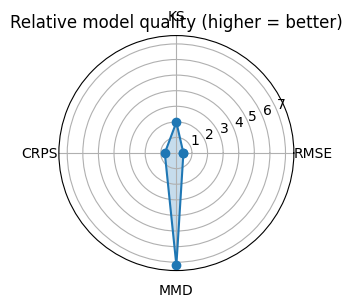

In [ ]:
# =============================================================
# STEP-9  –  Model & outcome evaluation
# =============================================================
import os, json, time, warnings, psutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats   import ks_2samp
from sklearn.metrics import pairwise_distances
from sklearn.feature_selection import mutual_info_regression
warnings.filterwarnings("ignore");   np.random.seed(42)

# ---------------- paths ----------------
DATA_PATH        = "./final_processed_data.csv"
SCEN_NPZ         = "./scenarios/scenario_paths.npz"      # Step-7 output
WEIGHTS_CSV      = "./portfolio/optimal_weights.csv"     # Step-8 output
EVAL_DIR         = "./eval/"; os.makedirs(EVAL_DIR, exist_ok=True)

# ---------------- helper: CRPS ----------------
def crps_ensemble(obs, sims):
    """Continuous Ranked Prob. Score for a scalar obs vs (N,) sims."""
    sims = np.sort(sims)
    n    = sims.size
    term = np.abs(sims - obs).mean()
    pair = (np.abs(sims.reshape(-1,1) - sims).sum() / (2*n*n))
    return term - pair

# ---------------- helper: MMD -----------------
def mmd_rbf(X, Y, gamma=1.0):
    """Unbiased MMD^2 with RBF kernel."""
    XX = np.exp(-gamma*pairwise_distances(X,  X, "sqeuclidean"))
    YY = np.exp(-gamma*pairwise_distances(Y,  Y, "sqeuclidean"))
    XY = np.exp(-gamma*pairwise_distances(X,  Y, "sqeuclidean"))
    n, m = len(X), len(Y)
    return XX[np.triu_indices(n,1)].mean() + \
           YY[np.triu_indices(m,1)].mean() - 2*XY.mean()

t0 = time.time()

# =============================================================
# 1 - Load real test data (same slice as Steps 6-8)
# =============================================================
df = (pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
        .drop(columns=["Inflation_YoY_diff"], errors="ignore"))
cols = df.columns.tolist(); idx = {c:i for i,c in enumerate(cols)}
test_real = df.iloc[int(.85*len(df)):]                    # 2021-06 →

# =============================================================
# 2 - Load synthetic baseline paths
# =============================================================
paths = np.load(SCEN_NPZ, allow_pickle=True)["baseline"]  # (N,12,F)
last  = paths[:,-1,:]                                     # compare last step
real_last = test_real.iloc[-paths.shape[0]:].values       # align length

# =============================================================
# 3 - Forecast metrics
# =============================================================
metrics = {}
rmse = np.sqrt(((last - real_last)**2).mean(0))
ks   = [ks_2samp(real_last[:,i], last[:,i]).statistic for i in range(len(cols))]
crps = [crps_ensemble(real_last[:,i], last[:,i]) for i in range(len(cols))]
mmd  = mmd_rbf(real_last, last, gamma=0.5)

metrics["RMSE"] = dict(zip(cols, rmse.round(3)))
metrics["KS"]   = dict(zip(cols, np.round(ks ,3)))
metrics["CRPS"] = dict(zip(cols, np.round(crps,3)))
metrics["MMD"]  = round(float(mmd), 4)

# =============================================================
# 4 - Causal-integrity check  I(Infl,Return | GS10)
# =============================================================
def cmi(x, y, z, n_bins=6):
    """quick discrete conditional MI"""
    xyz = np.column_stack([x, y, z])
    bins = [np.quantile(col, np.linspace(0,1,n_bins+1))[1:-1] for col in xyz.T]
    disc = [(np.digitize(col, b)).astype(int) for col,b in zip(xyz.T,bins)]
    Xd,Yd,Zd = disc
    mi_xyz = mutual_info_regression(np.column_stack([Xd,Zd]), Yd, discrete_features=True)[0]
    mi_xz  = mutual_info_regression(Zd.reshape(-1,1), Xd, discrete_features=True)[0]
    return mi_xyz - mi_xz      # crude but indicative

cmi_real = cmi(test_real["Inflation_YoY"].values,
               test_real["SP500_Returns"].values,
               test_real["GS10_Level"].values)
cmi_syn  = cmi(last[:,idx["Inflation_YoY"]],
               last[:,idx["SP500_Returns"]],
               last[:,idx["GS10_Level"]])
metrics["CMI_Infl_Eq_given_GS10"] = dict(real=round(float(cmi_real),4),
                                        synthetic=round(float(cmi_syn),4))

# =============================================================
# 5 - Portfolio realism gap (uses Step-8 CSV)
# =============================================================
tbl = pd.read_csv(WEIGHTS_CSV, index_col=0)
gap = (tbl["ex_cvar"] - tbl["realised_cvar"]).to_dict()
metrics["CVaR_gap"] = {k: round(float(v),3) for k,v in gap.items()}

# =============================================================
# 6 - Runtime & memory
# =============================================================
metrics["runtime_sec"] = round(time.time()-t0,2)
metrics["rss_mb"]      = round(psutil.Process().memory_info().rss/1e6,1)

# save
json.dump(metrics, open(f"{EVAL_DIR}eval_metrics.json","w"), indent=2)
print("Saved metrics →", f"{EVAL_DIR}eval_metrics.json")

# =============================================================
# 7 - Radar plot of main scores
# =============================================================
import matplotlib.pyplot as plt
lbl = ["RMSE", "KS", "CRPS", "MMD"]
vals= [np.mean(list(metrics[m].values())) if m!="MMD" else metrics["MMD"] for m in lbl]
# normalise small=good to big=good
vals_norm = 1/np.array(vals)

angles = np.linspace(0,2*np.pi,len(lbl),endpoint=False).tolist()
vals_c = np.concatenate([vals_norm,[vals_norm[0]]])
angles += angles[:1]

fig=plt.figure(figsize=(3.4,3.4)); ax=plt.subplot(111,polar=True)
ax.plot(angles, vals_c, "o-", lw=1.5); ax.fill(angles, vals_c, alpha=.25)
ax.set_xticks(angles[:-1]); ax.set_xticklabels(lbl)
ax.set_title("Relative model quality (higher = better)")
plt.tight_layout(); plt.savefig(f"{EVAL_DIR}radar_eval.png", dpi=180)

print("✅  Step-9 finished – artefacts stored in", EVAL_DIR)